In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn import model_selection, metrics, dummy

import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Chargement des données

In [3]:
import pickle

with open("./data/pickle", 'rb') as f:
    data_X, data_Y = pickle.load(f)

In [4]:
# 0 pour les données sans star, 1 pour energystar
data_X = data_X[0]
data_Y = data_Y[0]

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler().fit(data_Y)

In [7]:
#data_Y = pd.DataFrame(scaler.transform(data_Y), columns=data_Y.columns, index=data_Y.index)

## Liste des colonnes utilisables

In [8]:
col_num = list(data_X.select_dtypes(include=['float', 'int', 'uint8']).columns)

# Prédiction simple

Pas de sélection, juste pour observer différents algos en CV (dont leur stabilité)

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, MultiTaskLassoCV

In [10]:
def launch_kfold(model, X, y, splits=8, silence=False):
    kf = KFold(n_splits=splits)
    score_final = {'R2':0, 'RMSE':0, 'MAE':0}
    
    donnees_min = {'R2':1, 'iloc':None, 'pred':None}
    donnees_max = {'R2':-1, 'iloc':None, 'pred':None}

    for train, test in kf.split(X):
        # Entraînement
        model.fit(X.iloc[train], y.iloc[train])

        # Prédiction sur le jeu de test
        y_pred = model.predict(X.iloc[test])

        y_test = y.iloc[test]

        # Evaluate
        score = metrics.r2_score(y_test, y_pred)
        if not silence:
            print('R2 : ', score)
        score_final['R2'] += abs(score)
        
        if score < donnees_min['R2']:
            donnees_min['R2'] = score
            donnees_min['iloc'] = test.copy()
            donnees_min['pred'] = y_pred.copy()
        
        if score > donnees_max['R2']:
            donnees_max['R2'] = score
            donnees_max['iloc'] = test.copy()
            donnees_max['pred'] = y_pred.copy()

        score = metrics.mean_squared_error(y_test, y_pred, squared=True)
        score_final['RMSE'] += score

        score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
        score_final['MAE'] += score

    if not silence:
        for k, score in score_final.items():
            print('Score {} final : {}'.format(k, score/kf.get_n_splits()))
    
    return donnees_max, donnees_min

### Partie pour detecter les outliers réguliers
aka les lignes qui ne sont jamais bien prédites

In [11]:
def get_outliers(data_test, data_pred, outliers={}, step=0, limit=20):
    data_pred = pd.Series(data_pred, index=data_test.index).rename('Pred')

    compare_result = pd.concat([data_test.rename('Test'), data_pred], axis=1)
    compare_result['Diff'] = (compare_result['Test'] - compare_result['Pred']).abs()
    compare_result = compare_result.sort_values(by='Diff', ascending=False)
    
    for i in compare_result.head(limit).index:
        if i not in outliers:
            outliers[i] = 1-step
        else:
            outliers[i] += 1-step
    
    return outliers

In [12]:
outliers = {}

In [13]:
'''
for _ in range(50):
    idx = np.random.permutation(data_X.index)
    data_X = data_X.reindex(idx)
    data_Y = data_Y.reindex(idx)

    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)
    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)
    print(donnees_min['R2'])
    if donnees_min['R2'] < 0.6 :
        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)
'''

"\nfor _ in range(50):\n    idx = np.random.permutation(data_X.index)\n    data_X = data_X.reindex(idx)\n    data_Y = data_Y.reindex(idx)\n\n    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)\n    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)\n    print(donnees_min['R2'])\n    if donnees_min['R2'] < 0.6 :\n        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)\n"

In [14]:
# pd.DataFrame(outliers.items()).sort_values(by=1, ascending=False).head(20)

Suppression de ces valeurs

In [15]:
for i in []:#[304, 426, 3206]:
    data_X = data_X.drop(index=i)
    data_Y = data_Y.drop(index=i)

## Test de différents regressors

In [16]:
print('KFold avec DummyRegressor :')
dum = dummy.DummyRegressor(strategy='median')
launch_kfold(dum, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec Lasso :')
regr = MultiTaskLassoCV(cv=5)
launch_kfold(regr, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec XGBoost :')
xgbreg = XGBRegressor()
launch_kfold(xgbreg, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec RandomForest :')
regr = RandomForestRegressor(max_depth=50)
donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y)

KFold avec DummyRegressor :
R2 :  -0.00010600845413577531
R2 :  -0.015334909383678985
R2 :  -0.03879773421016186
R2 :  -0.0056180570437387445
R2 :  -0.0028804771052639566
R2 :  -0.020374041566368017
R2 :  -0.0033269968009268513
R2 :  -0.010247187614237818
Score R2 final : 0.012085676522314001
Score RMSE final : 1.8746915608644485
Score MAE final : 1.0812978026242517



 KFold avec Lasso :
R2 :  0.6202085744486536
R2 :  0.7493990729247959
R2 :  0.6931800347313638
R2 :  0.7194916066193355
R2 :  0.6525442467584873
R2 :  0.7481887005559773
R2 :  0.7318456260418018
R2 :  0.6801539323264534
Score R2 final : 0.6993764743008586
Score RMSE final : 0.5555333379462082
Score MAE final : 0.5672519604437332



 KFold avec XGBoost :
R2 :  0.649776823291013
R2 :  0.7247757905277328
R2 :  0.7032681911282039
R2 :  0.7035080532339962
R2 :  0.6942316658430513
R2 :  0.7195624828135345
R2 :  0.7565371267309067
R2 :  0.6610523043668171
Score R2 final : 0.7015890547419069
Score RMSE final : 0.5495864748954773

## Affichage des features importance

In [17]:
def get_features_importance(model, X, y, plot=False):
    model.fit(X, y)
    importance = model.feature_importances_

    list_col = X.columns.to_list()
    list_features = []
    for i, v in pd.Series(importance).sort_values(ascending=False).items():
        list_features.append([list_col[i],v])
    
    list_features = pd.DataFrame(list_features, columns=['Nom', 'Value'])
    
    if plot:
        list_features.head(20).plot.barh(x='Nom', y='Value', figsize=(7,7))
    
    return list_features

,Nom,Value
0,PropertyGFATotal,0.107569
1,Type_Self-storage facility,0.081663
2,Type_Supermarket/grocery store,0.061179
3,Type_Laboratory,0.046764
4,Type_Worship facility,0.042930
...,...,...
66,Type_Financial office,0.000000
67,Type_Hospital,0.000000
68,Type_Social/meeting hall,0.000000
69,Type_Performing arts,0.000000


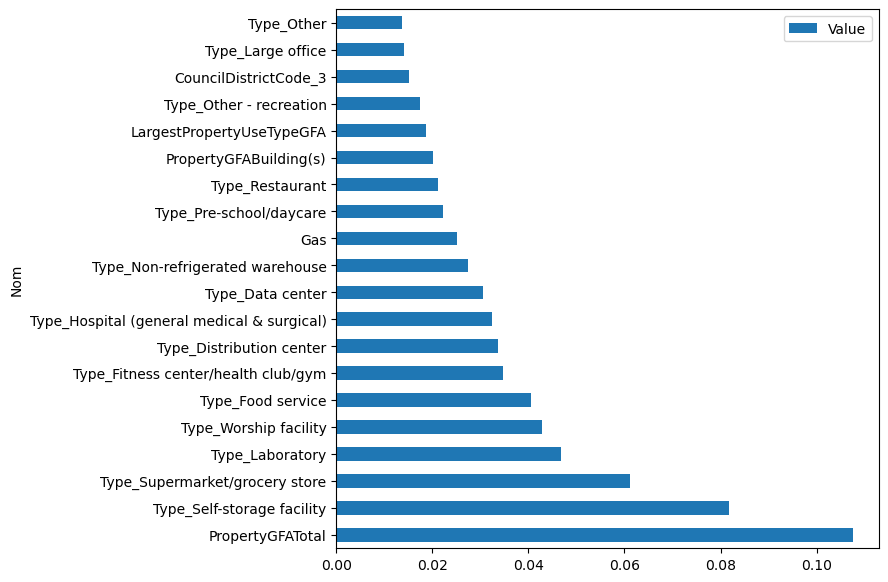

In [18]:
model = RandomForestRegressor(max_depth=30)
model = XGBRegressor()

get_features_importance(model, data_X[col_num], data_Y['Energy_Y'], True)

# GridSearch sur plusieurs algos

In [19]:
TARGET = 'Energy_Y' #'Energy_Y', 'CO2_Y'

In [20]:
from sklearn.model_selection import GridSearchCV
import time

list_models = []

def grid_search_cv_models(X, y, models, params):
    global list_models
    best_score = 0
    best_model = None
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

    for model, model_params in zip(models, params):
        gs = GridSearchCV(model, model_params, cv=5, error_score='raise', refit='r2', scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        
        # Entraîner le modèle sur les données X et y
        gs.fit(X_train, y_train)
        
        print("\n"*5, str(gs.best_estimator_), '\n')
        
        nom_estimator = str(gs.best_estimator_)
        
        list_models.append({"name":nom_estimator[:nom_estimator.index('(')], "clf":gs.best_estimator_})
        
        tab_cv_result = pd.DataFrame(gs.cv_results_)
        
        print(tab_cv_result[['mean_fit_time', 'mean_score_time', 'mean_test_r2']]) # 'params', 
        
        tab_cv_result = tab_cv_result.loc[tab_cv_result['rank_test_r2']==1]
        
        print("Temps d'entrainement : ", tab_cv_result['mean_fit_time'].to_list()[0])
        print("Temps de prédiction : ", tab_cv_result['mean_score_time'].to_list()[0])
        
        for n, m in [('R2', 'r2'), ('RMSE', 'neg_root_mean_squared_error'), ('MAE', 'neg_mean_absolute_error')]:
            mean = tab_cv_result['mean_test_'+m].to_list()[0]
            std = tab_cv_result['std_test_'+m].to_list()[0]
            
            if n!='R2':
                mean = -mean
                
            print("Score {} : {:.4f} Deviation : {:.4f}".format(n, mean, std))
        
        
        #print(tab_cv_result.columns)
        print('\nTest sur les données restantes :')
        
        start_time = time.time()
        trained_estimator = gs.best_estimator_.fit(X_train, y_train)
        print("Temps d'entrainement : ", time.time() - start_time)
        
        start_time = time.time()
        y_pred = trained_estimator.predict(X_test)
        print("Temps de prédiction : ", time.time() - start_time)
        
        for n, m in [('R2', metrics.r2_score),
                     ('RMSE', metrics.mean_squared_error),
                     ('MAE', metrics.mean_absolute_error)]:
            score = m(y_test, np.abs(y_pred))
            
            if n=='RMSE':
                score = sqrt(score)
            
            print("Score {} : {:.4f}".format(n, score))
        
        # Si le meilleur score de ce modèle est supérieur au meilleur score actuel, le mettre à jour
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
    # Renvoyer le meilleur modèle
    return best_model

In [21]:
# Une liste de modèles
models = [dummy.DummyRegressor(), KNeighborsRegressor(), LassoCV(), RandomForestRegressor(), Ridge(), LinearRegression(), Lasso(), BayesianRidge(), XGBRegressor()]
# Une liste de paramètres pour les modèles correspondants
params = [{'strategy':['mean', 'median']},
          {'n_neighbors':[5, 10, 15, 30], 'weights':['distance']},
          {'cv':[2, 3, 4, 5, 6, 8]},
          {"max_depth": [3, 5, 10, 20, 30, 50, 75, 100]},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {'alpha_init':[1, 1.4, 1.9],
           'lambda_init': [1e-1, 1e-3, 1e-5]},
          {"learning_rate": [0.10, 0.15],
            "max_depth": [3, 5],
            "min_child_weight": [2, 3, 4],
            "gamma":[0.0, 0.05],
            "colsample_bytree":[0.3, 0.4]}]


best_model = grid_search_cv_models(data_X[col_num], data_Y[TARGET], models, params)
print("Le meilleur modèle est:", best_model)






 DummyRegressor() 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.000000         0.003126     -0.008763
1       0.003124         0.000000     -0.019545
Temps d'entrainement :  0.0
Temps de prédiction :  0.003125572204589844
Score R2 : -0.0088 Deviation : 0.0103
Score RMSE : 1.3111 Deviation : 0.0492
Score MAE : 1.0516 Deviation : 0.0388

Test sur les données restantes :
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0013
Score RMSE : 1.2474
Score MAE : 1.0040





 KNeighborsRegressor(n_neighbors=10, weights='distance') 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.003619         0.098362      0.614690
1       0.002819         0.075234      0.617878
2       0.010071         0.119362      0.613103
3       0.009684         0.153336      0.601737
Temps d'entrainement :  0.0028191089630126955
Temps de prédiction :  0.07523417472839355
Score R2 : 0.6179 Deviation : 0.0368
Score RMSE : 0.8051 Deviation : 0.0289
Score MAE : 0.6079 Deviation

Temps d'entrainement :  0.2292940616607666
Temps de prédiction :  0.010066032409667969
Score R2 : 0.7553
Score RMSE : 0.6166
Score MAE : 0.4725
Le meilleur modèle est: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


## Analyse et comparaison des algos
avec les meilleurs hypermarametres sélectionnés

In [22]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [23]:
from sklearn.ensemble import VotingRegressor

tmp_reg = []
for e in list_models:
    if e['name'] in ['BayesianRidge', 'LassoCV']:
        tmp_reg.append((e['name'], e['clf']))

reg = VotingRegressor(estimators=tmp_reg)
list_models.append({'name':'Voting-Bay-Lasso', 'clf':reg})

name
DummyRegressor           0.000000
LinearRegression         0.409878
Lasso                    0.644237
KNeighborsRegressor      0.644257
RandomForestRegressor    0.716374
Ridge                    0.723017
Voting-Bay-Lasso         0.730976
BayesianRidge            0.731475
LassoCV                  0.733301
XGBRegressor             0.745444
Name: test_accuracy, dtype: float64


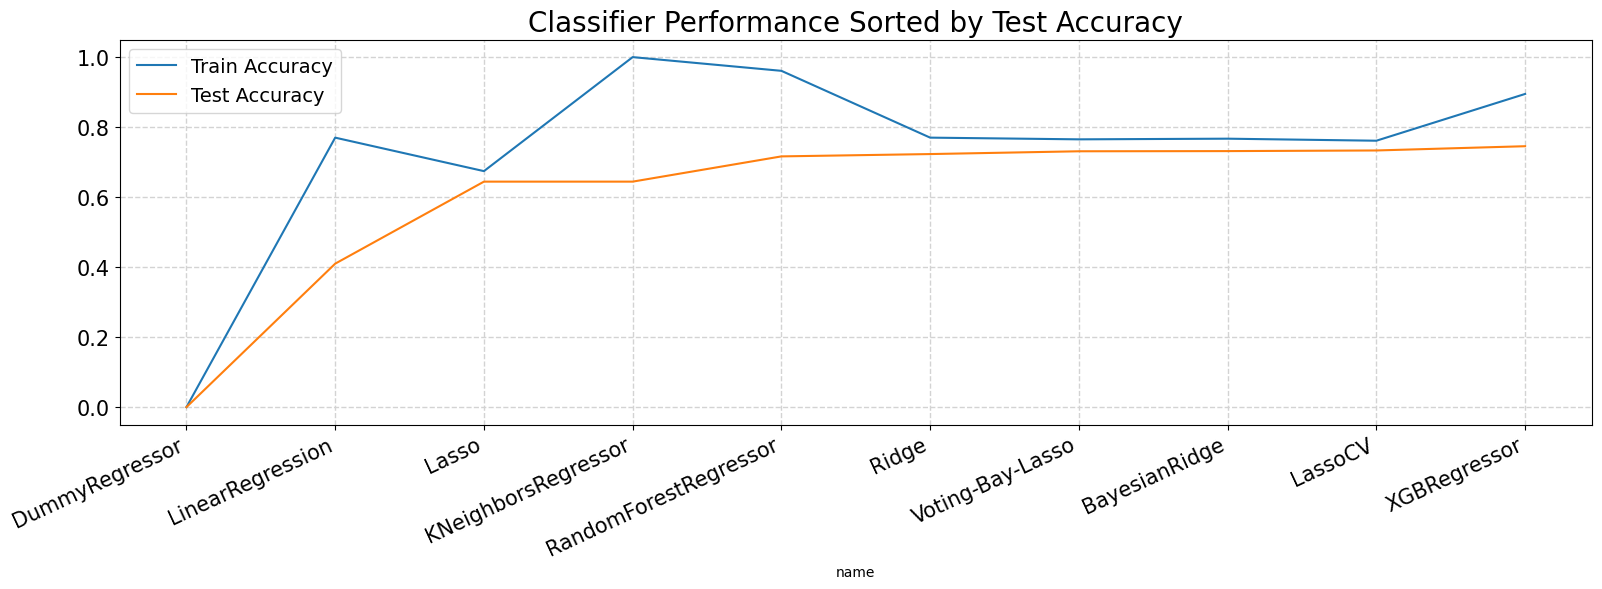

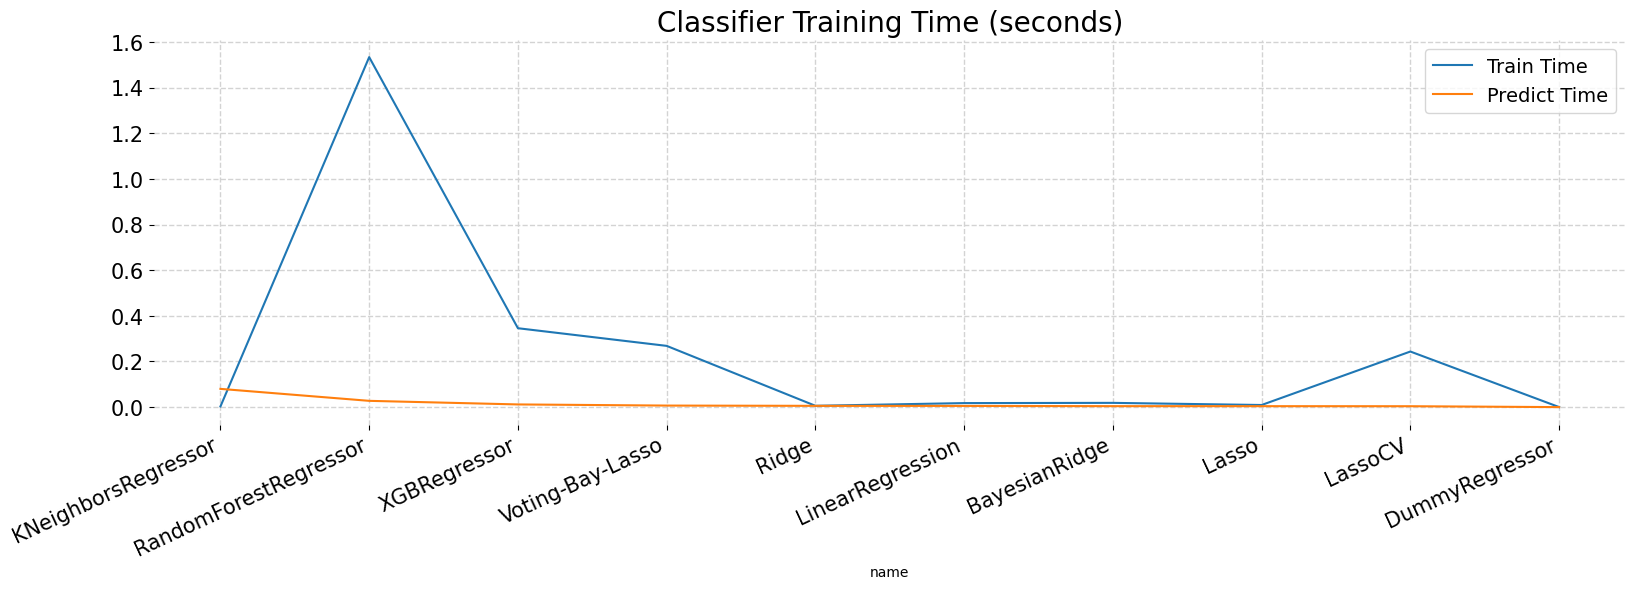

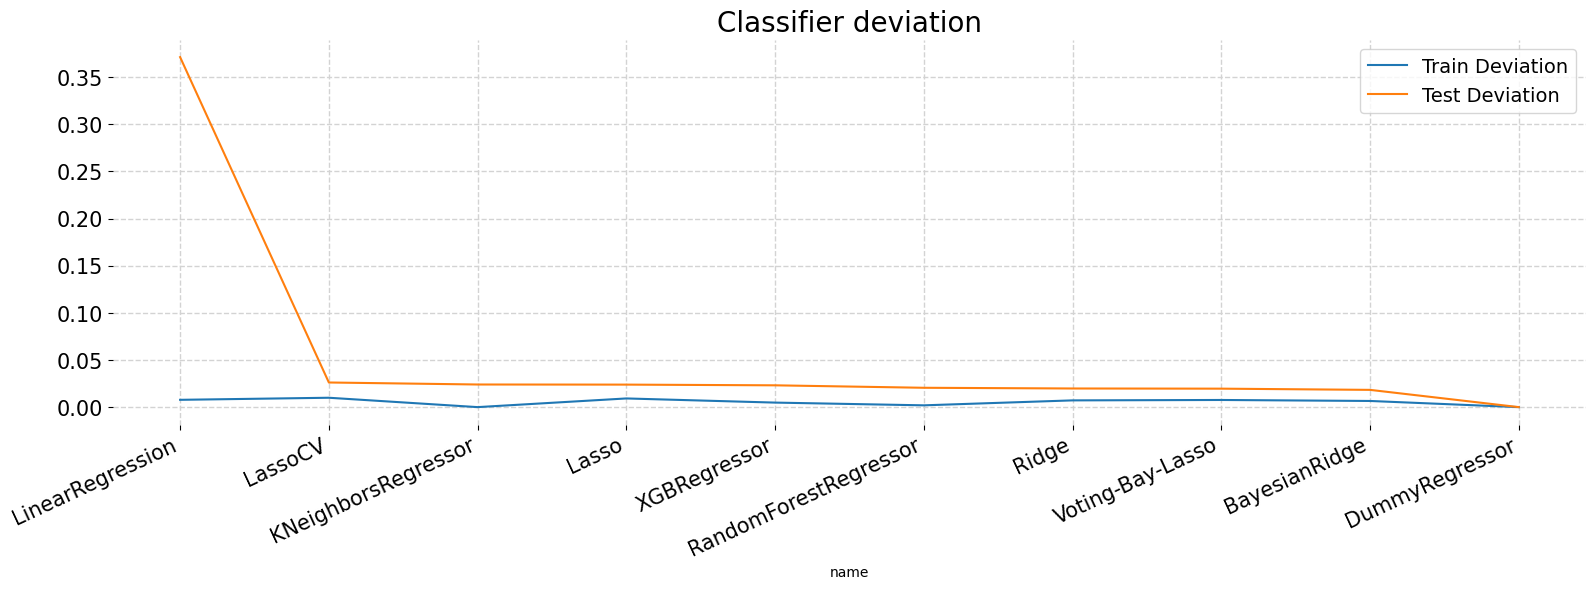

In [24]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
    X = data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    
    start_time = time.time()
    trained_model = model["clf"].fit(X_train, y_train)
    train_time = time.time() - start_time

    
    start_time = time.time()
    y_pred = trained_model.predict(X_test)
    predict_time = time.time() - start_time
    
    test_score = metrics.r2_score(y_test, y_pred)
    test_score = max(test_score, 0)
    
    y_pred = trained_model.predict(X_train)
    train_score = metrics.r2_score(y_train, y_pred)
    train_score = max(train_score, 0)
    
    model_details = {"name": model["name"], "test_accuracy": test_score, "train_accuracy": train_score, "train_time": train_time, "predict_time": predict_time}
    return model_details

models = [
          {"name": "Dummy Regressor", "clf": dummy.DummyRegressor()},
          {"name": "KNN", "clf": KNeighborsRegressor(n_neighbors=10, weights='distance')},
          {"name": "LassoCV", "clf": LassoCV(cv=50)}, 
          {"name": "Lasso", "clf": Lasso(alpha=0.1)},
          {"name": "RandomForestRegressor", "clf": RandomForestRegressor(max_depth=75)},
          {"name": "Ridge", "clf": Ridge(alpha=0.89)}, 
          {"name": "LinearRegression", "clf": LinearRegression()}, 
          {"name": "BayesianRidge", "clf": BayesianRidge()},
          {"name": "Best Model", "clf": best_model}]

for model in list_models*25:
    model_details = train_model(model, data_X[col_num], data_Y[TARGET]) 
    trained_models.append(model_details)


    
# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models).groupby('name').mean()
model_df.sort_values("test_accuracy", inplace=True)
print(model_df["test_accuracy"])
ax = model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
ax.title.set_size(20)
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
#plt.xticks(rotation=90)

model_df.sort_values("predict_time", inplace=True, ascending=False)
ax= model_df[["train_time", "predict_time"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time", "Predict Time"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False)  


model_df = pd.DataFrame(trained_models).groupby('name').std()
model_df.sort_values("test_accuracy", inplace=True, ascending=False)
ax= model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier deviation")
ax.title.set_size(20)
ax.legend(["Train Deviation", "Test Deviation"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False) 

In [25]:
import shap

In [26]:
shap.initjs()

In [27]:
shap_model = BayesianRidge(alpha_init=1, lambda_init=0.1)#LassoCV(cv=5)
shap_model.fit(data_X[col_num], data_Y[TARGET])

explainer = shap.LinearExplainer(shap_model, data_X[col_num], feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

In [28]:
#shap_model = XGBRegressor().fit(data_X[col_num], data_Y[TARGET])

In [29]:
#explainer = shap.Explainer(shap_model, feature_names=col_num)
#shap_values = explainer.shap_values(data_X[col_num])

In [30]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=col_num)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


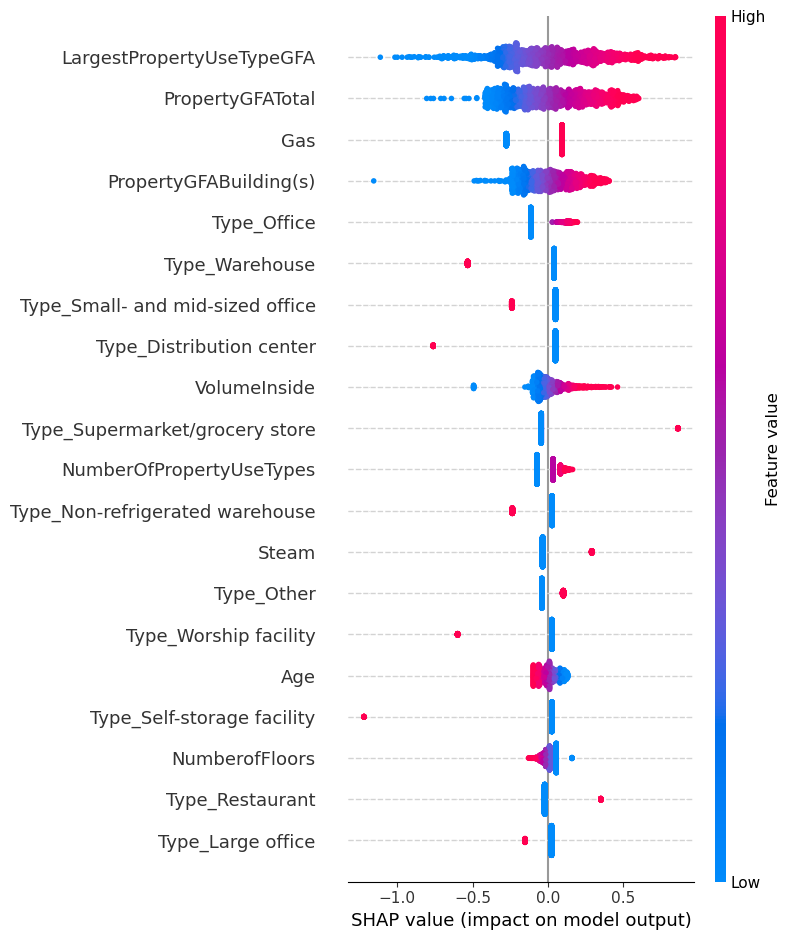

In [31]:
shap.summary_plot(shap_values, data_X[col_num])

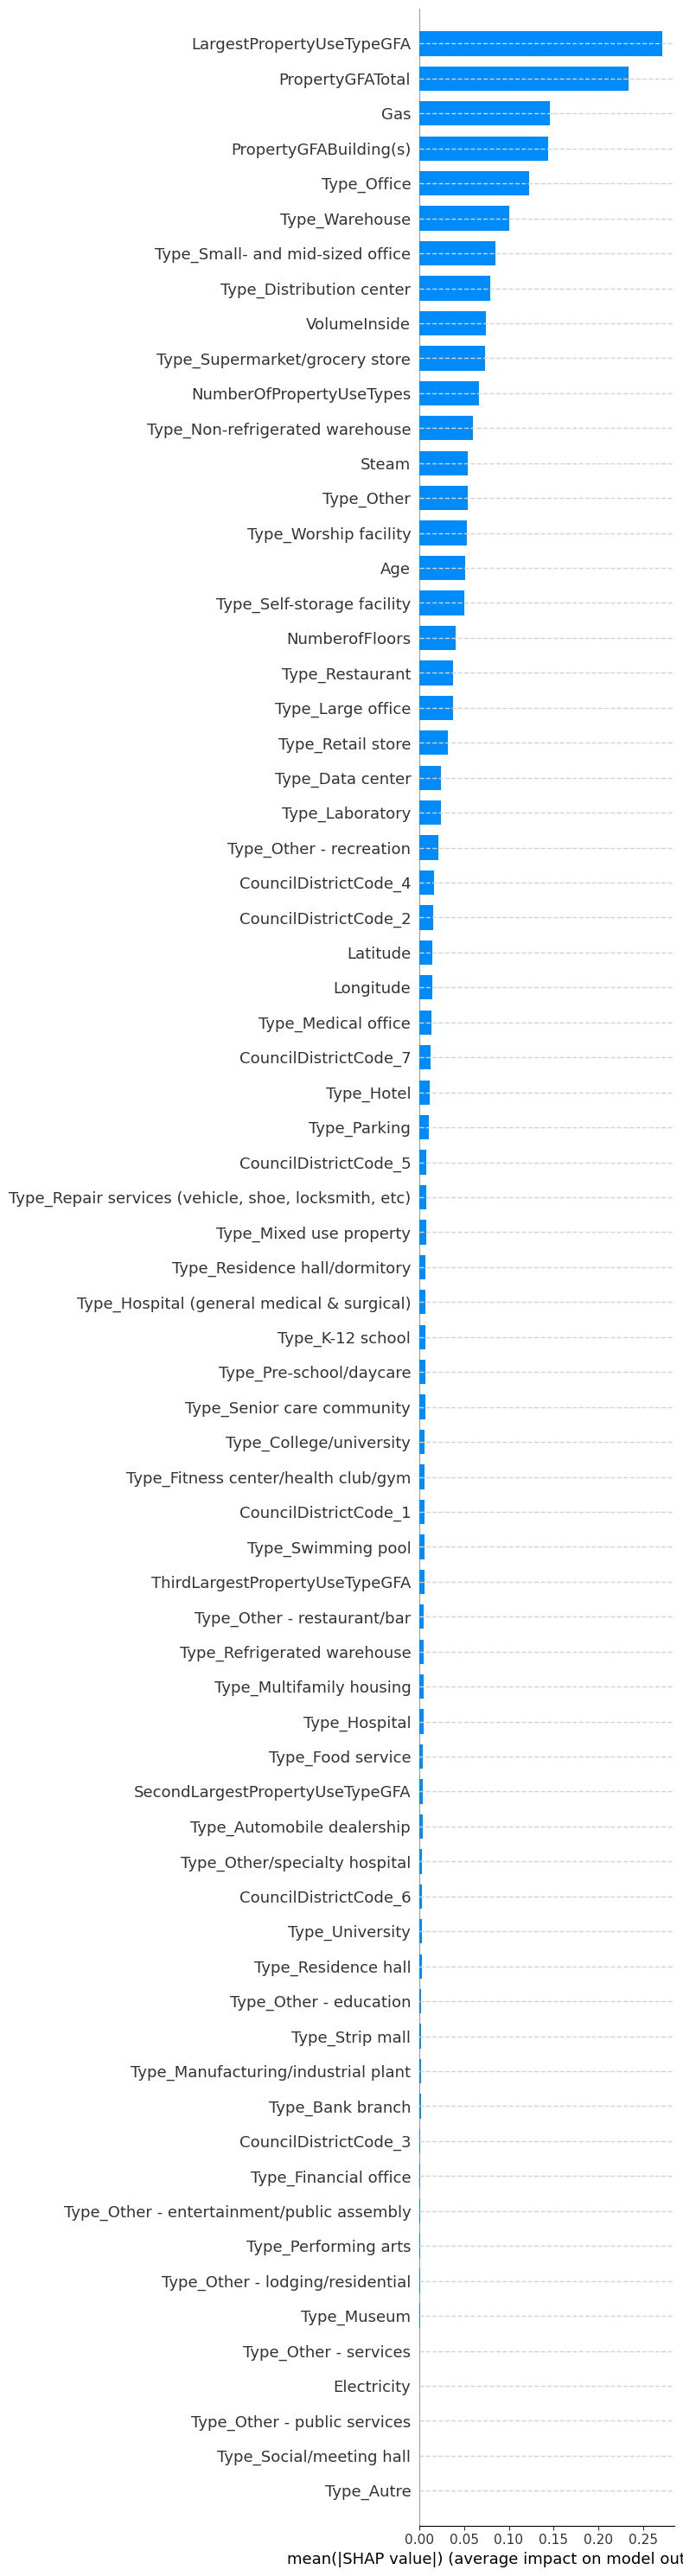

In [32]:
shap.summary_plot(shap_values, data_X[col_num], plot_type="bar", max_display=300)

In [64]:
output = 'Energy_Y'
algo = 'bay'

In [65]:
y_hist = pd.DataFrame(columns=['Test', 'Predict'])

In [66]:
kf = KFold(n_splits=8)

for train, test in kf.split(data_X):
    X_train, y_train = data_X[col_num].iloc[train], data_Y[output].iloc[train]
    X_test, y_test = data_X[col_num].iloc[test], data_Y[output].iloc[test]
    
    model = BayesianRidge(alpha_init=1, lambda_init=0.1)
    if algo == 'XGB':
        model = XGBRegressor()
    model.fit(X_train, y_train)
    y_predict = pd.Series(model.predict(X_test), index=y_test.index)
    
    y_hist_tmp = pd.concat([y_test, y_predict], axis=1)
    y_hist_tmp.columns=['Test', 'Predict']
    
    y_hist = pd.concat([y_hist, y_hist_tmp])

In [67]:
y_hist['Diff'] = np.log(np.abs(np.exp(y_hist['Test'])-np.exp(y_hist['Predict'])))

In [68]:
y_hist

,Test,Predict,Diff
2051,14.853700,14.370675,13.894202
640,15.771512,14.912838,15.220344
1623,14.599292,14.949737,13.731075
2027,13.731854,14.254258,13.355088
534,15.682391,14.819829,15.134073
...,...,...,...
819,14.945583,14.774208,13.097221
1220,15.315349,14.916548,14.203273
328,17.695147,17.199703,16.755329
3322,15.423326,15.480744,12.594774


In [69]:
import seaborn as sns

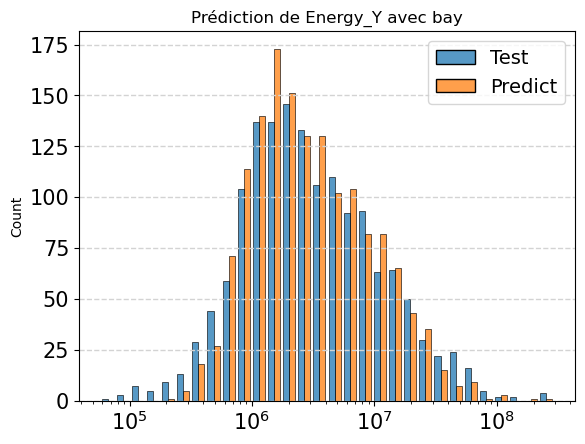

In [70]:
ax = sns.histplot(np.exp(y_hist[['Test', 'Predict']]), multiple="dodge", shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Prédiction de {} avec {}".format(output, algo))

fig = ax.get_figure()
fig.savefig("./data/graph/predict_{}_{}.png".format(output, algo)) 

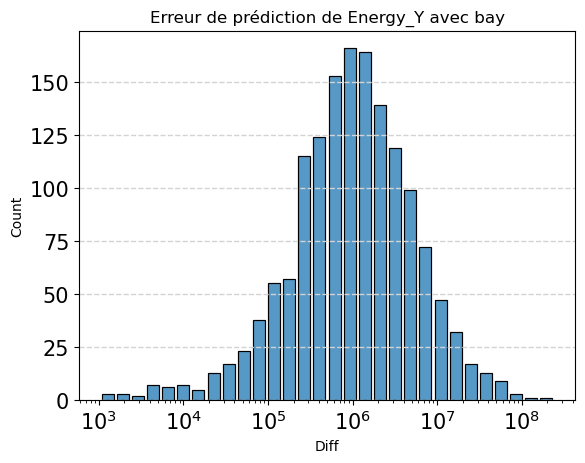

In [71]:
ax = sns.histplot(np.exp(y_hist['Diff']), shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Erreur de prédiction de {} avec {}".format(output, algo))

fig = ax.get_figure()
fig.savefig("./data/graph/erreur_{}_{}.png".format(output, algo)) 

<AxesSubplot: xlabel='Test', ylabel='Predict'>

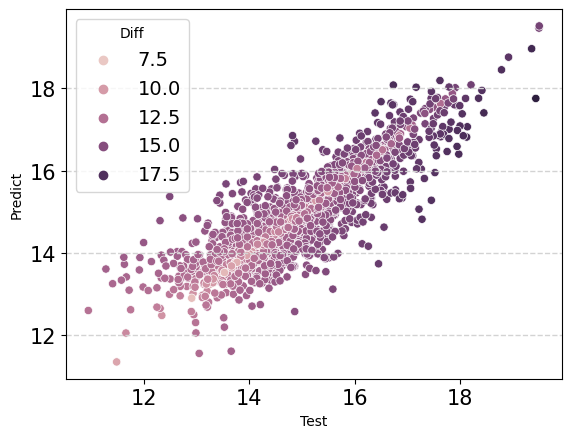

In [41]:
sns.scatterplot(y_hist, x='Test', y='Predict', hue='Diff')

In [42]:
annee_tranform = [(i, i*0.0334408 - 2.2) for i in range(0, 200, 5)]

In [43]:
model = BayesianRidge(alpha_init=1, lambda_init=0.1)
model.fit(data_X[col_num], data_Y['CO2_Y'])

BayesianRidge(alpha_init=1, lambda_init=0.1)

In [44]:
data_X_modif = data_X.loc[[1], col_num]

In [45]:
data_X.loc[[1], 'Age']

1   -1.058339
Name: Age, dtype: float64

In [46]:
for i, i_pt in annee_tranform:
    data_X_modif_tmp = data_X_modif.copy()
    data_X_modif_tmp['Age'] = i_pt
    print(i, np.exp(model.predict(data_X_modif_tmp)[0]))

0 282.11277910134413
5 281.77705097314276
10 281.441722377981
15 281.1067928403946
20 280.77226188548497
25 280.4381290389196
30 280.1043938269294
35 279.7710557763102
40 279.43811441442006
45 279.10556926917957
50 278.7734198690716
55 278.44166574314016
60 278.1103064209893
65 277.77934143278264
70 277.4487703092439
75 277.1185925816543
80 276.7888077818536
85 276.45941544223814
90 276.1304150957607
95 275.80180627593035
100 275.47358851681133
105 275.1457613530218
110 274.8183243197338
115 274.491276952673
120 274.1646187881177
125 273.8383493628974
130 273.5124682143929
135 273.1869748805362
140 272.86186889980826
145 272.5371498112403
150 272.21281715441114
155 271.88887046944785
160 271.5653092970251
165 271.2421331783641
170 270.91934165523173
175 270.59693426994
180 270.2749105653462
185 269.9532700848516
190 269.6320123724004
195 269.3111369724796


In [47]:
np.exp(data_Y.loc[[1]])

,Energy_Y,CO2_Y
1,8387932.5,296.860016
